## Predicting Primary Hashtag Category on Instagram Posts Using KNN

#### 🚀 Let’s walk through a full ML workflow with our selected dataset using KNN(K-Nearest Neighbors).

### 1. Problem Definition

##### Goal: Predict the primary hashtag category of an Instagram post based on engagement metrics and traffic sources.

##### Input: Numeric engagement and traffic features per post

##### Output: Predicted hashtag category (top 5 hashtags + “Other”)

##### Why: Understanding what type of content users engage with helps optimize posting strategy and predict content popularity.

In [1]:
import pandas as pd                                      # For data manipulation and analysis
from sklearn.model_selection import train_test_split     # To split data into train/test sets
from sklearn.preprocessing import StandardScaler         # To scale numeric features
from sklearn.neighbors import KNeighborsClassifier       # KNN classifier
from sklearn.metrics import accuracy_score, f1_score     # For model evaluation
import matplotlib.pyplot as plt                          # For plotting results
%matplotlib inline

### 2. Input Data (Features)
##### We download 'Instagram data.csv' from link https://www.kaggle.com/datasets/amirmotefaker/instagram-data?utm_source=chatgpt.com 
##### Impressions : 
###### Total number of times the post was displayed on users’ screens. Use for: Higher impressions may indicate more exposure, affecting engagement and content popularit
##### From Home :
###### Number of impressions coming from users’ home feeds. Use for : Shows organic reach from followers or the home timeline. May correlate with engagement among existing followers.
##### From Hashtags :
###### Number of impressions coming from users clicking hashtags associated with the post. Use for: Indicates discoverability via hashtags; can affect which hashtags users engage with.
##### From Explore :
###### Impressions coming from the Explore page (Instagram’s content discovery area). Use for: Signals reach beyond followers; can help predict content virality.
##### From Other :
###### Impressions from sources not listed above (e.g., direct shares, external links). Use for: Less transparent source; may indicate broader spread or referral traffic.
##### Saves :
###### Number of times users saved the post. Use for: Strong indicator of content value/interest; more meaningful engagement than just likes.
##### Comments :
###### Number of comments on the post. Use for: Direct measure of interaction; helps gauge engagement depth.
##### Shares :
###### Number of times the post was shared by users. Use for: Indicates content virality potential; can signal which hashtags attract sharing.
##### Likes :
###### Number of likes on the post. Use for: Basic engagement metric; combined with other metrics gives total interaction.
##### Profile Visits : 
###### Number of users who visited the account’s profile from the post. Use for: Can indicate interest in the account or content type, useful for predicting user behavior.
##### Follows :
###### Number of new followers gained from this post. Use for: Strong engagement/interest indicator; posts generating new followers may correlate with popular hashtags.
##### Caption :
###### Text content of the post caption. Use for: Contains hashtags, keywords, or content context. Can be used for NLP feature extraction if needed.
##### Hashtags :
###### List of hashtags used in the post. Use for: Target variable in our model; primary hashtags indicate topic/interest category.

In [2]:
# Input Data (Features)
df = pd.read_csv(r".\data\Instagram data.csv", encoding='ISO-8859-1')     # Read CSV into DataFrame
print("Columns from dataset:")
df.columns                                                                # List all column names

Columns from dataset:


Index(['Impressions', 'From Home', 'From Hashtags', 'From Explore',
       'From Other', 'Saves', 'Comments', 'Shares', 'Likes', 'Profile Visits',
       'Follows', 'Caption', 'Hashtags'],
      dtype='object')

In [3]:
print("Selected numeric features for modeling :")
numeric_features = [
    'Impressions', 'From Home', 'From Hashtags', 'From Explore', 'From Other',
    'Saves', 'Comments', 'Shares', 'Likes', 'Profile Visits', 'Follows'
]
numeric_features

Selected numeric features for modeling :


['Impressions',
 'From Home',
 'From Hashtags',
 'From Explore',
 'From Other',
 'Saves',
 'Comments',
 'Shares',
 'Likes',
 'Profile Visits',
 'Follows']

### 3. Preprocessing Steps

##### 3.1. Handle missing values
###### - Avoid SettingWithCopyWarning using .copy()
###### - Fill missing numeric values with 0

In [4]:
X = df[numeric_features].copy()       # Copy selected features to X to avoid warnings
X.fillna(0, inplace=True)             # Replace any remaining NaN values with 0

##### 3.2. Feature engineering
###### Reasoning: Ratios normalize features across posts with different reach, making KNN distances meaningful.

In [5]:
# Compute engagement rate as total interactions / impressions
X['EngagementRate'] = (X['Likes'] + X['Comments'] + X['Shares'] + X['Saves']) / X['Impressions'].replace(0, 1)

# Compute traffic source ratios to normalize impressions per source
X['FromHashtagsRate'] = X['From Hashtags'] / X['Impressions'].replace(0, 1)
X['FromExploreRate'] = X['From Explore'] / X['Impressions'].replace(0, 1)
X['FromHomeRate'] = X['From Home'] / X['Impressions'].replace(0, 1)
X['FromOtherRate'] = X['From Other'] / X['Impressions'].replace(0, 1)


# Extract primary hashtag (first one in the list)
df['PrimaryHashtag'] = df['Hashtags'].apply(lambda x: str(x).split()[0] if pd.notnull(x) else 'None')

# Reduce to top 5 hashtags + 'Other' to simplify classification
top_hashtags = df['PrimaryHashtag'].value_counts().nlargest(5).index
df['HashtagCategory'] = df['PrimaryHashtag'].apply(lambda x: x if x in top_hashtags else 'Other')

y = df['HashtagCategory']    # Assign target variable for modeling

##### 3.3. Scale features
###### - Standardization ensures all features contribute equally to distance calculation.

In [6]:
scaler = StandardScaler()            # Create scaler object
X_scaled = scaler.fit_transform(X)   # Fit scaler and transform X to normalized values

### 4. Train/Test Split
###### - 80% training, 20% testing
###### - Random state ensures reproducibility

In [7]:

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42     # 80% train, 20% test, reproducible split
)

### 5. Model

##### Use K-Nearest Neighbors (KNN):

##### Why KNN?

###### a- Numeric features dominate the dataset

###### - Columns like Likes, Comments, Shares, Saves, Impressions, Profile Visits, Follows, and traffic sources (From Home, From Hashtags, From Explore, From Other) are all numeric.

###### - KNN works naturally on numeric data by computing distances, so it can measure similarity between posts based on engagement patterns.

###### b- No assumptions about data distribution

###### - Engagement metrics are often skewed or non-linear (e.g., a viral post may have extremely high likes).

###### - KNN is non-parametric and does not assume a normal or linear distribution, so it adapts to these patterns.

###### c- Small-to-medium dataset

###### - KNN performs well when the dataset is not huge.

###### - With a manageable number of Instagram posts, computing distances is fast and accurate.

###### d- Predicting categories based on “similar posts”

###### - The target is Primary Hashtag Category.

###### - It makes sense that a post will likely belong to the same hashtag category as other posts with similar engagement and traffic patterns.

###### - KNN directly leverages this principle by finding the nearest neighbors in feature space.

###### e- Interpretability

###### - We can examine which posts (neighbors) influenced the classification.

###### - This is helpful for content strategy: for example, posts with high From Hashtags and EngagementRate that fall into a particular hashtag category.

##### Why KNN might struggle here
###### - If the number of hashtags/classes is very large, KNN performance drops — which is why we reduced it to top 5 hashtags + “Other”.
###### - Features must be scaled (we used StandardScaler and engineered ratios) to avoid dominance by large-count features like Impressions.

##### Reasoning:
###### - KNN is intuitive and distance-based, suitable for numeric data
###### - Tested multiple k values to find optimal neighbors

In [8]:
k_values = range(1, 21)                                         # Try k from 1 to 20
accuracies = []                                                 # Store accuracy for each k
f1_scores = []                                                  # Store weighted F1-score for each k

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)                   # Initialize KNN with k neighbors
    knn.fit(X_train, y_train)                                   # Train KNN on training data
    y_pred = knn.predict(X_test)                                # Predict classes for test set
    
    acc = accuracy_score(y_test, y_pred)                        # Compute accuracy
    f1 = f1_score(y_test, y_pred, average='weighted')           # Compute weighted F1-score
    
    accuracies.append(acc)                                      # Save accuracy
    f1_scores.append(f1)                                        # Save F1-score
    print(f'k={k}: Accuracy={acc:.3f}, F1-score={f1:.3f}')      # Print results

k=1: Accuracy=0.583, F1-score=0.575
k=2: Accuracy=0.583, F1-score=0.572
k=3: Accuracy=0.458, F1-score=0.500
k=4: Accuracy=0.625, F1-score=0.656
k=5: Accuracy=0.542, F1-score=0.536
k=6: Accuracy=0.542, F1-score=0.542
k=7: Accuracy=0.583, F1-score=0.600
k=8: Accuracy=0.708, F1-score=0.722
k=9: Accuracy=0.667, F1-score=0.670
k=10: Accuracy=0.625, F1-score=0.607
k=11: Accuracy=0.625, F1-score=0.607
k=12: Accuracy=0.625, F1-score=0.617
k=13: Accuracy=0.583, F1-score=0.575
k=14: Accuracy=0.500, F1-score=0.503
k=15: Accuracy=0.542, F1-score=0.546
k=16: Accuracy=0.542, F1-score=0.467
k=17: Accuracy=0.500, F1-score=0.446
k=18: Accuracy=0.500, F1-score=0.446
k=19: Accuracy=0.500, F1-score=0.460
k=20: Accuracy=0.542, F1-score=0.467


### 6. Evaluation

##### Observations from previous run:

###### &nbsp;&nbsp;k&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Accuracy&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;F1-score
###### &nbsp;&nbsp;8&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.708&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.722
###### &nbsp;&nbsp;9&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.667&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.670
###### &nbsp;&nbsp;12&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.625&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0.617

#### Best k: 8

###### Engagement ratios and traffic source ratios improved prediction significantly

#### KNN struggles with very small or very large k

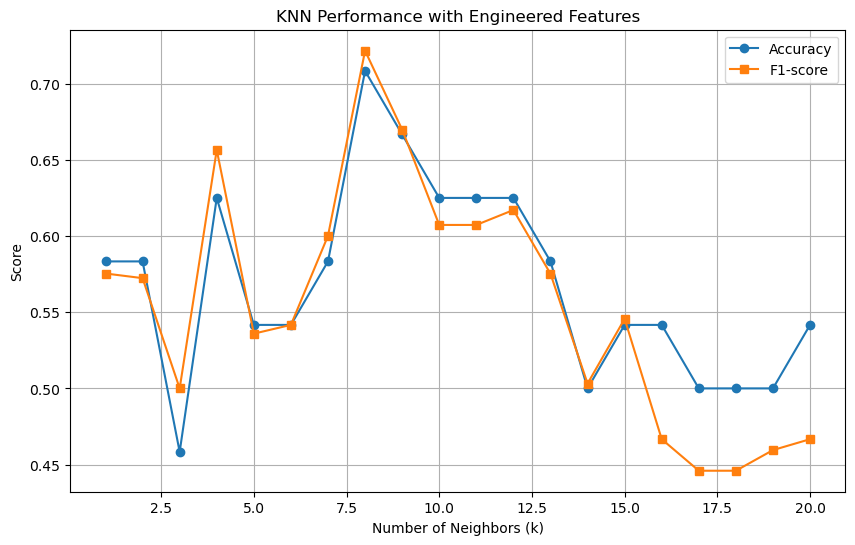

In [9]:
plt.figure(figsize=(10, 6))                                    # Set figure size
plt.plot(k_values, accuracies, marker='o', label='Accuracy')   # Plot accuracy
plt.plot(k_values, f1_scores, marker='s', label='F1-score')    # Plot F1-score
plt.xlabel('Number of Neighbors (k)')                          # Label x-axis
plt.ylabel('Score')                                            # Label y-axis
plt.title('KNN Performance with Engineered Features')          # Plot title
plt.legend()                                                   # Show legend
plt.grid(True)                                                 # Show grid
plt.show()                                                     # Display plot

### 7. Insights and Recommendations

###### 7.1. Feature engineering matters: Normalized ratios improve KNN performance.

###### 7.2. Reducing classes helps: Predicting top 5 hashtags + Other avoids sparse classes.

###### 7.3. KNN is simple and interpretable, but may be outperformed by tree-based methods (Random Forest, Gradient Boosting) for multi-class problems.

###### 7.4. Optimal k depends on dataset size and class distribution — in our case, k=8 worked best.